# MMDS Course Project: System Detecting Bots

## Make sure the notebook is connected to http server where jupyter/pyspark-notebook docker container runs
1. Download the docker image
> docker pull jupyter/pyspark-notebook
2. Start the container by mounting the project folder "./mount" to default folder within the container "/home/jovyan/work"
> docker run -it --rm -p 8888:8888 -v ./mount:/home/jovyan/work jupyter/pyspark-notebook
3. Add the localhost:8888 to the jupyter kernels and connect the notebook

## Install the necessary modules inside on the docker container

In [ ]:
!pip install numpy==1.23.5 pandas==1.5.3 scikit-learn==1.2.2 seaborn==0.12.2 ipykernel==6.25.2 sseclient==0.0.27 tqdm==4.65.0 yellowbrick==1.4

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.model_selection import FeatureImportances

import argparse
import json
from csv import DictWriter
from sseclient import SSEClient as EventSource
from tqdm import tqdm
from datetime import datetime, timedelta
from typing import Generator, Dict
from pandas import DataFrame

## Sampling from Wikimedia Recent Changes stream

In [44]:
past_datetime = datetime.now() - timedelta(weeks=2)
since_timestamp = int(past_datetime.timestamp() * 1000)
URL = f'https://stream.wikimedia.org/v2/stream/recentchange?since={since_timestamp}'
SAMPLE_FILE = f"./sampled_events_id.csv"

### Definitions

In [43]:
def is_relevant_event(event: Dict, wiki='enwiki') -> bool:
    """
    Checks if the event is relevant for sampling, i.e., it is an edit made by a bot on the specified wiki topic.

    Args:
    - event (dict): The event data.
    - wiki (str): The wiki to filter for (default is 'enwiki').

    Returns:
    - bool: True if the event is an edit by a bot in the specified wiki, False otherwise.
    """
    return  event.get('type') != None and event.get('type') == 'edit' and event.get('wiki') == wiki


def should_sample_event(event: Dict, sample_by: str, threshold: float = 0.2) -> bool:
    """
    Determines if an event should be sampled based on threshold.

    Args:
    - event (dict): The event data containing fields for sampling.
    - sample_by (str): The event field we sample by.
    - threshold (float): Probability threshold for sampling (default: 0.2 for 20%).

    Returns:
    - bool: True if the event should be sampled, False otherwise.
    """
    sample_by_value = event.get(sample_by, "")
    if sample_by_value == "":
        return False

    time_hash_val = abs(hash(sample_by_value)) % 100 / 100
    return time_hash_val < threshold


def write_event_to_csv(writer: DictWriter, event):
    """
    Writes a single event to the CSV file.

    Args:
    - writer (csv.DictWriter): The CSV writer object.
    - event (dict): The event data to be written.
    """
    row = {
        'bot': event['bot'],
        'user': event['user'],
        'timestamp': event['timestamp'],
        'namespace': event['namespace'],
        'title': event['title'],
        'comment': event.get('comment', ''),
        'length_old': event['length']['old'],
        'length_new': event['length']['new'],
        'revision_old': event['revision']['old'],
        'revision_new': event['revision']['new'],
    }
    writer.writerow(row)


def subscribe_to_stream(url: str, wiki: str='enwiki') -> Generator[Dict, None, None]:
    """
    Subscribes to the Wikimedia recent changes stream and yields relevant events.

    Args:
    - url (str): The URL of the Wikimedia recent changes stream.
    - wiki (str): The wiki to filter for (default is 'enwiki').

    Yields:
    - dict: A dictionary representing a relevant bot edit event.
    """
    for event in EventSource(url):
        if event.event == 'message':
            try:
                change = json.loads(event.data)
            except ValueError:
                continue

            if is_relevant_event(change, wiki=wiki):
                yield change


def sample_to_csv(events: Generator, output_file: str, sample_by: str, threshold: float=0.2, sample_limit: int=40000):
    """
    Samples events and writes them to a CSV file up to a specified limit.

    Args:
    - events (iterable): An iterable of events to be sampled.
    - output_file (str): The filename for the output CSV file.
    - interval_size (int): The size of the time interval in seconds (60 seconds by default).
    - threshold (float): Probability threshold for sampling (0.2 for 20%).
    - sample_limit (int): The maximum number of samples to collect.
    """
    csv_fields = ['bot', 'user', 'timestamp', 'namespace', 'title', 'comment', 'length_old', 'length_new', 'revision_old', 'revision_new']
    
    with open(output_file, mode='w', newline='', encoding='utf-8') as csv_file:
        writer = DictWriter(csv_file, fieldnames=csv_fields)
        writer.writeheader()

        sample_count = 0
        with tqdm(total=sample_limit, desc=f"Sampling {threshold*100:.0f}%", unit="sample", miniters=1) as prog_bar:
            for event in events:
                if sample_count >= sample_limit:
                    break

                if should_sample_event(event, sample_by, threshold):
                    write_event_to_csv(writer, event)
                    sample_count += 1
                    prog_bar.update(1)

    print(f"Sampling complete. {sample_count} edits written to {output_file}")


### Run Sampling

In [ ]:
events = subscribe_to_stream(URL, wiki='enwiki')
sample_to_csv(
    events = events,
    output_file = SAMPLE_FILE,
    sample_by = "id",
    threshold = 0.2,
    sample_limit = 40000
)

## Train and test Random Forest Classifier for binary classification of Bot vs Human

### Data preparation

In [35]:
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [48]:
def preprocess(data: DataFrame) -> DataFrame:
    """
    Preprocesses the data by applying count vectorization and TF-IDF transformation.

    Args:
    - data (DataFrame): The input data.

    Returns:
    - DataFrame: The same data frame object with new pre-processed columns.
    """
    data['timestamp2'] = pd.to_datetime(data['timestamp'], unit='s')
    data['hour_num'] = data['timestamp2'].dt.hour
    data['namespace_num'] = data['namespace'].fillna(-1)
    data['comment'] = data['comment'].fillna('no comment')
    data['comment_len_num'] = data['comment'].apply(len)
    data['comment_word_num'] = data['comment'].apply(lambda x: len(x.split()))
    data['comment_count_vec_num'] = count_vectorizer.fit_transform(data['comment']).sum(axis=1)
    data['comment_tfidf_num'] = tfidf_vectorizer.fit_transform(data['comment']).sum(axis=1)
    data['bot_num'] = data['bot'].apply(lambda x : 1 if x == True else 0)

    return data

data = preprocess(pd.read_csv(SAMPLE_FILE, parse_dates=['timestamp']))

### Distribution between humans and bots in the sample dataset

False    30639
True      9361
Name: bot, dtype: int64


<Axes: title={'center': 'True Bots vs Humans Samples'}>

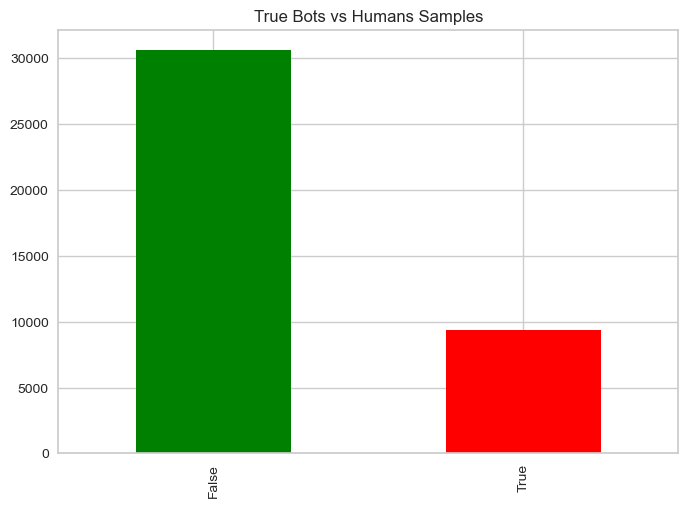

In [70]:
print(data['bot'].value_counts())
data['bot'].value_counts().plot(kind='bar', title='True Bots vs Humans Samples', color=['green', 'red'])


### Model training and evaluation

In [51]:

y = data['bot_num']
X = data[['comment_len_num', 'comment_word_num', 'comment_count_vec_num', 
          'comment_tfidf_num', 'namespace_num', 'hour_num'
        ]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train))
print(len(X_test))

32000
8000


In [71]:
type(y_test)

pandas.core.series.Series

In [52]:
clf = RandomForestClassifier(max_depth=10, n_estimators=100,random_state=0)
clf = clf.fit(X_train, y_train)

In [53]:
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 97.40%


/opt/miniconda3/envs/mmds-env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


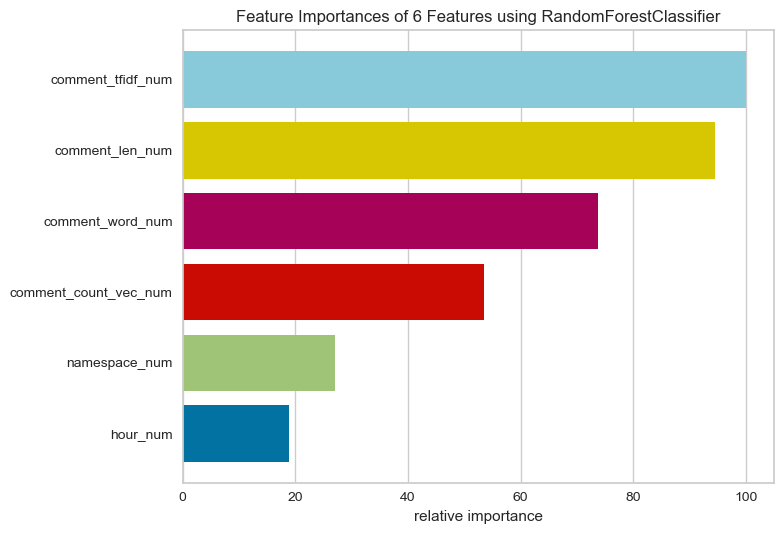

<Axes: title={'center': 'Feature Importances of 6 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [54]:
viz = FeatureImportances(clf)
viz.fit(X_train, y_train)
viz.show()

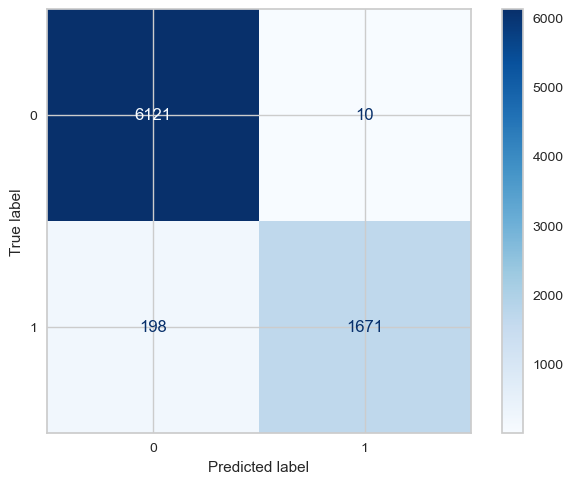

In [57]:
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

In [62]:
misclassified_indices = np.where(y_test != y_pred)[0]
print('Misclassified:', len(misclassified_indices))
FN = np.where((y_test == True) & (y_pred == False))[0]
print('FN:', len(FN))
FP = np.where((y_test == False) & (y_pred == True))[0]
print('FP:', len(FP))


Misclassified: 208
FN: 198
FP: 10


## Finally, train a Bloom Filter that filter out bots from the stream.*
- *Find the correct parameters for the bloom filter having an error around 10%*

Bloom filter is characterized by:
- size of a bit array ($m$)
- number of hash functions

where optimal $m$ can be calculated as:
$$m=-\frac{n*ln(p)}{ln(2)^{2}}$$
,where n is a number of items (bots in our case)\
and number of hash functions as:
$$k=\frac{m}{n}ln(2)$$

So, for the training to start we need to evaluate a number of bots from our sample.

In [1]:
import pandas as pd

def count_true_rows(file_path: str) -> int:
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Count rows where 'flag' is True
    count_true = df['bot'].sum() if 'bot' in df else 0

    return count_true

In [4]:
import numpy as np

p = 0.1  # 10% error rate

n = count_true_rows('./sampled_events_id.csv')
m = - n * np.log(p) / np.log(2)**2
k = np.log(2) * m / n

print(f"for n={n} array size (m) is {m}, k is {k}")

n = count_true_rows('./sampled_events_timestamp.csv')
m = - n * np.log(p) / np.log(2)**2
k = np.log(2) * m / n

print(f"for n={n} array size (m) is {m}, k is {k}")

for n=9361 array size (m) is 44862.86573526829, k is 3.3219280948873617
for n=9138 array size (m) is 43794.13172619182, k is 3.3219280948873617


So, ~44kb array and 3 hash functions are sufficient to store a bloom filter trained with 40k samples.

In [ ]:
import hashlib

def hashes(value, num_hashes, size):
    h1 =  int(hashlib.md5(value.encode()).hexdigest(), 16) % size
    h2 =  int(hashlib.sha256(value.encode()).hexdigest(), 16) % size
    if h2 == 0:
        h2 = 1
    return [(h1 + i * h2) % size for i in range(num_hashes)]

class BloomFilter:
    def __init__(self, size: int, hash_count: int):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = [0] * size

    def add(self, item: str):
        for index in hashes(item, self.hash_count, self.size):
            self.bit_array[index] = 1

    def add_all(self, items: list):
        for item in items:
            self.add(item)

    def contains(self, item: str) -> bool:
        for index in hashes(item, self.hash_count, self.size):
            if self.bit_array[index] == 0:
                return False
        return True


In [ ]:
df = pd.read_csv('ucu-mmds/src/homework2/sampled_events_id.csv')

filter = BloomFilter(int(m), int(k)+1)
filter.add_all(df['user'].to_list())

In [ ]:
print(filter.contains(df['user'][3]))  # True
print(filter.contains('$@@##'))  # True

True
False
